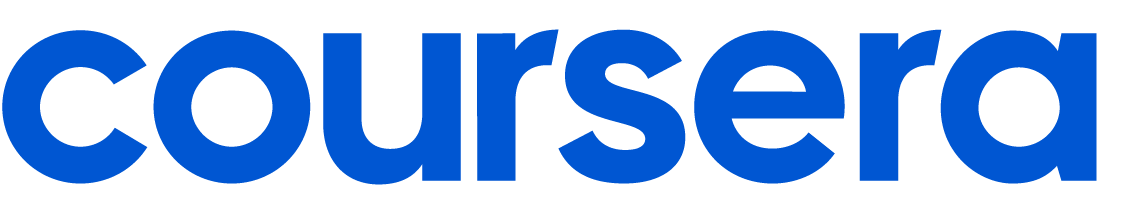

## Introduction

Subscription services are leveraged by companies across many industries, from fitness to video streaming to retail. One of the primary objectives of companies with subscription services is to decrease churn and ensure that users are retained as subscribers. In order to do this efficiently and systematically, many companies employ machine learning to predict which users are at the highest risk of churn, so that proper interventions can be effectively deployed to the right audience.

In this challenge, we will be tackling the churn prediction problem on a group of subscribers on a video streaming service! 

We'll be building a model that can predict which existing subscribers will continue their subscriptions for another month. The dataset is a sample of subscriptions that were initiated in 2021, all snapshotted at a particular date before the subscription was cancelled. Subscription cancellation can happen for a multitude of reasons, including:
* the customer completes all content they were interested in, and no longer need the subscription
* the customer finds themselves to be too busy and cancels their subscription until a later time
* the customer determines that the streaming service is not the best fit for them, so they cancel and look for something better suited

Regardless the reason, this video streaming company has a vested interest in understanding the likelihood of each individual customer to churn in their subscription so that resources can be allocated appropriately to support customers.

## Understanding the Datasets

### Train vs. Test
In this competition, there are two datasets that are samples of past subscriptions of a video streaming platform that contain information about the customer, the customers streaming preferences, and their activity in the subscription thus far. One dataset is titled `train.csv` and the other is titled `test.csv`.

`train.csv` contains 70% of the overall sample (243,787 subscriptions to be exact) and importantly, will reveal whether or not the subscription was continued into the next month (the “ground truth”).

The `test.csv` dataset contains the exact same information about the remaining segment of the overall sample (104,480 subscriptions to be exact), but does not disclose the “ground truth” for each subscription.

### Dataset descriptions
Both `train.csv` and `test.csv` contain one row for each unique subscription. For each subscription, a single observation (`CustomerID`) is included during which the subscription was active. 

In addition to this identifier column, the `train.csv` dataset also contains the target label for the task, a binary column `Churn`.

Besides that column, both datasets have an identical set of features that can be used to train your model to make predictions. Below you can see descriptions of each feature.

In [16]:
import pandas as pd
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


## Import Python Modules

First, import the primary modules that will be used in this project. Remember as this is an open-ended project please feel free to make use of any of your favorite libraries that you feel may be useful for this challenge. For example some of the following popular packages may be useful:

- pandas
- numpy
- Scipy
- Scikit-learn
- keras
- maplotlib
- seaborn
- etc, etc

In [46]:
# import required packages

# data packages
import pandas as pd
import numpy as np

# machine learning / classification packages
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# visualization packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
# import any other packages you may want to use
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from tensorflow import keras

## Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df` and display the shape of the dataframes.

In [19]:
train_df = pd.read_csv("train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [20]:
test_df = pd.read_csv("test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


## EDA
Since predicting churn is a classfication task, We'll be working towards building a baseline interpretable logistic regression model first and moving forward from there.

Validating the data first, checking to see if there are any missing values, duplicate values, and mistyped data.

In [21]:
# check for missing values
missing = train_df.isna()
n_missing = train_df[missing].sum()

# check for duplicate values
duplicates = train_df['CustomerID'].duplicated()
n_duplicates = duplicates.sum()

print(f'Missing values: \n{n_missing}\n')
print(f'Duplicate values: {n_duplicates}')

Missing values: 
AccountAge                  0.0
MonthlyCharges              0.0
TotalCharges                0.0
SubscriptionType            0.0
PaymentMethod               0.0
PaperlessBilling            0.0
ContentType                 0.0
MultiDeviceAccess           0.0
DeviceRegistered            0.0
ViewingHoursPerWeek         0.0
AverageViewingDuration      0.0
ContentDownloadsPerMonth    0.0
GenrePreference             0.0
UserRating                  0.0
SupportTicketsPerMonth      0.0
Gender                      0.0
WatchlistSize               0.0
ParentalControl             0.0
SubtitlesEnabled            0.0
CustomerID                  0.0
Churn                       0.0
dtype: float64

Duplicate values: 0


In [22]:
# replicate for test set
testmissing = test_df.isna()
testn_missing = test_df[missing].sum()

# check for duplicate values
testduplicates = test_df['CustomerID'].duplicated()
testn_duplicates = duplicates.sum()

print(f'Missing values: \n{n_missing}\n')
print(f'Duplicate values: {n_duplicates}')

Missing values: 
AccountAge                  0.0
MonthlyCharges              0.0
TotalCharges                0.0
SubscriptionType            0.0
PaymentMethod               0.0
PaperlessBilling            0.0
ContentType                 0.0
MultiDeviceAccess           0.0
DeviceRegistered            0.0
ViewingHoursPerWeek         0.0
AverageViewingDuration      0.0
ContentDownloadsPerMonth    0.0
GenrePreference             0.0
UserRating                  0.0
SupportTicketsPerMonth      0.0
Gender                      0.0
WatchlistSize               0.0
ParentalControl             0.0
SubtitlesEnabled            0.0
CustomerID                  0.0
Churn                       0.0
dtype: float64

Duplicate values: 0


No missing or duplicate values appeared in the dataset. Based on the given data descriptions, there are a number of categorical features. Checking the unique values of the columns below, we'll likely need to refactor or encode these into numerical features to make modeling more efficient. We can also spot any mistyped or miscategorized data this way.

In [23]:
# function to check unique values
def unique_values(df):
       for column in df:
            print(f'{column}: {df[column].unique()}') 

# run for datasets
unique_values(train_df)
unique_values(test_df)

AccountAge: [ 20  57  73  32 113  38  25  26  14 114   3  64  43  98  47  11  50   5
  63  55  84  16  80 116  33  86  52  77   4  91 119  72  94  99  40  60
 105  54  34  67  49 100   6  97  24  53  82  18   8  29   9 101  30  74
  17  69  61  65  96  62  35  51 109  76   2  42 111  68  15  27  58 103
  45  36  85 107 115  81 106  70  46  83  92   1  44 118  23  88   7  31
  71  48  93 117  95  37 112  21 108  19  12  78 104  87  90 110  56  79
  41  13  28  10  59  39  75 102  89  66  22]
MonthlyCharges: [11.0552151   5.17520846 12.10665687 ... 14.51456873 18.14055532
 11.59377449]
TotalCharges: [ 221.10430197  294.98688225  883.78595161 ... 1640.14626689  126.98388725
 1043.4397042 ]
SubscriptionType: ['Premium' 'Basic' 'Standard']
PaymentMethod: ['Mailed check' 'Credit card' 'Electronic check' 'Bank transfer']
PaperlessBilling: ['No' 'Yes']
ContentType: ['Both' 'Movies' 'TV Shows']
MultiDeviceAccess: ['No' 'Yes']
DeviceRegistered: ['Mobile' 'Tablet' 'Computer' 'TV']
ViewingHoursPer

There are no apparent data value errors.

Now viewing the distributions of the target `Churn` alone and in relation to the features. This'll give insight on key predictors and any class imbalances.





In [24]:
# separate feature dataframes
# categorical features
c_df = train_df[['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference', 
                 'Gender', 'PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled', 'Churn']]
# numerical features
n_df = train_df[['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 
                 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize', 'SubtitlesEnabled', 'Churn']]

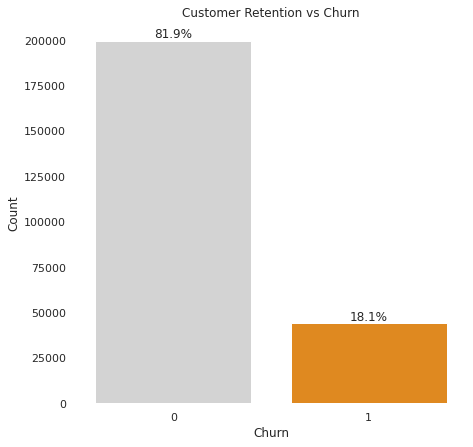

In [25]:
# visualizing churn
sns.set(style = "white")
plt.figure(figsize = (7, 7))

ax = sns.countplot(x = 'Churn', data = train_df, palette = {0: 'lightgrey', 1: 'darkorange'})
sns.despine(left = True, bottom = True)

total = len(train_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, f'{height/total:.1%}', ha = 'center', va = 'bottom')

plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Customer Retention vs Churn')
plt.show()

Observing the values of `Churn` shows that the classes are imbalanced - there are far more returning customers than churned customers. This is important to note, we may need to balance the classes or apply cross-validation to improve model prediction accuracy.

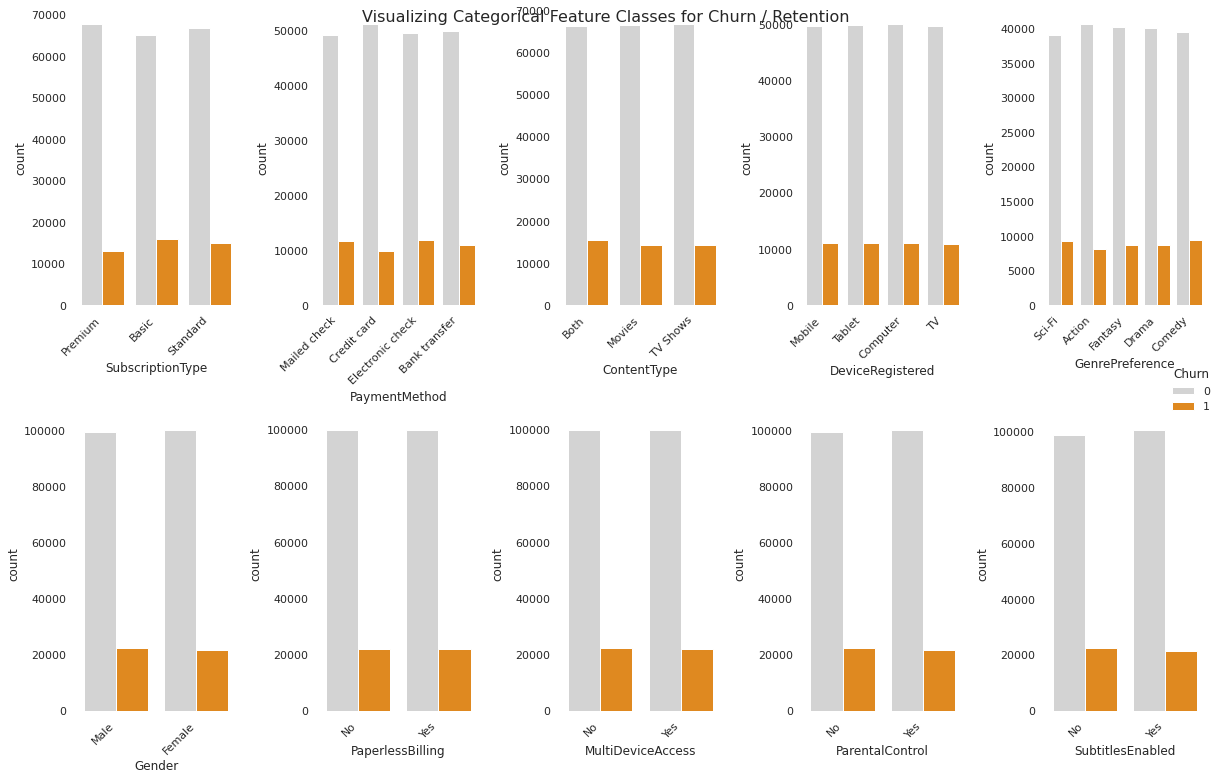

In [26]:
# categorical features bivariate analysis
# visualization grid
fig, axes = plt.subplots(2, 5, figsize = (17, 11))
axes = axes.flatten()

# category barplots for churn / retention
for ax, column in zip(axes, c_df.columns):
    sns.countplot(data = c_df, x = column, hue = 'Churn', palette = ['lightgrey', 'darkorange'], ax = ax)
    sns.despine(ax = ax, left = True, bottom = True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
    ax.legend_ = None

# show plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Churn', loc = 'center right', frameon = False)
plt.suptitle('Visualizing Categorical Feature Classes for Churn / Retention', fontsize = 16, fontweight = 'light')
fig.tight_layout()
plt.show()

Observing the rest of the cateogrical features in relation to `Churn` shows that the other features all have mostly balanced classes. There are no glaring differences between returning and churned customers for these fields.

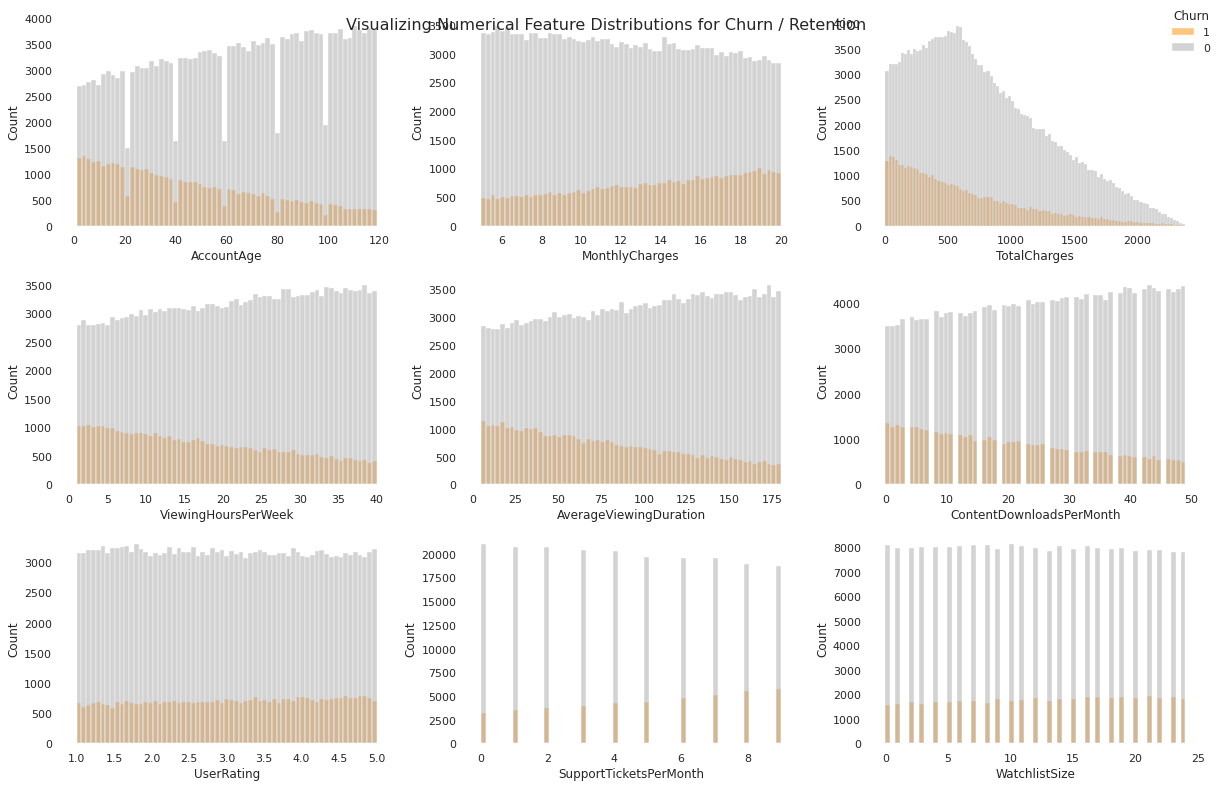

In [27]:
# numerical feature bivariate analysis
# visualization grid
fig, axes = plt.subplots(3, 3, figsize = (17, 11))

# variable distributions for churn / retention
for i, ax in enumerate(axes.flat):
    if i >= len(n_df.columns[:-1]):
        fig.delaxes(ax)
        continue

    feature = n_df.columns[i]
    sns.histplot(data = n_df, x = feature, hue = 'Churn', palette = {0: 'darkgrey', 1: 'darkorange'}, alpha = .51, edgecolor = None, ax = ax)
    sns.despine(ax = ax, bottom = True, left = True)
    ax.legend_ = None

# show plot
fig.legend(labels = [1, 0], loc = 'upper right', title = 'Churn', facecolor = 'white', edgecolor = 'None')
plt.suptitle('Visualizing Numerical Feature Distributions for Churn / Retention', fontsize=  16, fontweight = 'light')
plt.tight_layout()
plt.show()

Viewing numerical feature distributions for values of `Churn` reveals a few expected trends. Churned customers tend to have newer accounts, with less charges and viewing hours as a result. We can infer that newer customers are most likely to Churn.

In [28]:
# correlation matrix
n_df.add
corr = n_df.corr()
corr

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
AccountAge,1.000000,0.001706,0.820144,-0.001640,0.000191,0.001220,0.000440,-0.002055,-0.002640,-0.197736
MonthlyCharges,0.001706,1.000000,0.498207,-0.003029,-0.000604,-0.000127,0.000056,0.000071,-0.000540,0.100473
TotalCharges,0.820144,0.498207,1.000000,-0.003006,0.000860,0.000208,0.000609,-0.001770,-0.001770,-0.120529
ViewingHoursPerWeek,-0.001640,-0.003029,-0.003006,1.000000,0.000949,0.002149,-0.003185,0.000788,-0.000750,-0.128645
AverageViewingDuration,0.000191,-0.000604,0.000860,0.000949,1.000000,-0.002397,-0.000406,-0.000158,0.000749,-0.146897
ContentDownloadsPerMonth,0.001220,-0.000127,0.000208,0.002149,-0.002397,1.000000,0.001294,-0.000497,0.002324,-0.129752
UserRating,0.000440,0.000056,0.000609,-0.003185,-0.000406,0.001294,1.000000,-0.000142,0.002567,0.022124
SupportTicketsPerMonth,-0.002055,0.000071,-0.001770,0.000788,-0.000158,-0.000497,-0.000142,1.000000,0.001250,0.084064
WatchlistSize,-0.002640,-0.000540,-0.001770,-0.000750,0.000749,0.002324,0.002567,0.001250,1.000000,0.021739
Churn,-0.197736,0.100473,-0.120529,-0.128645,-0.146897,-0.129752,0.022124,0.084064,0.021739,1.000000


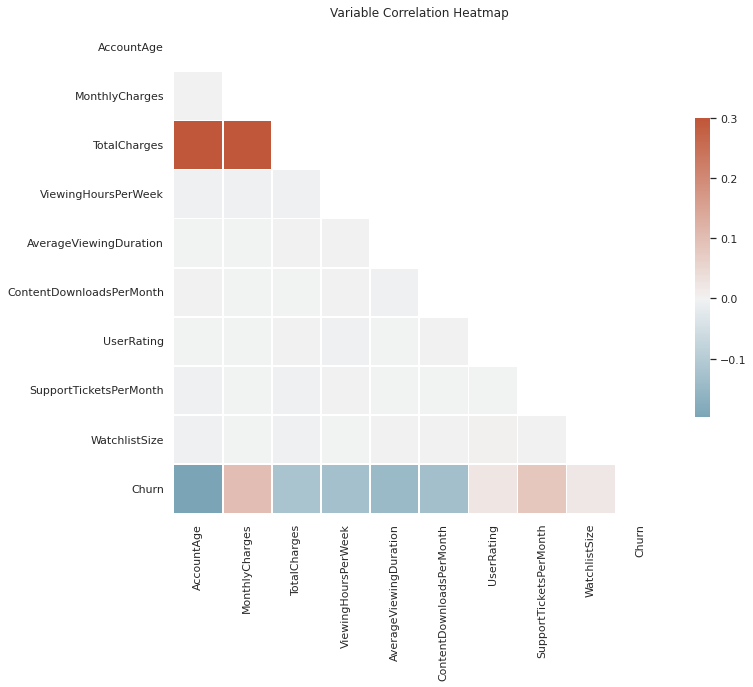

In [29]:
# heatmap
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (11, 11))
cmap = sns.diverging_palette(227, 21, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
           square = True, linewidths = .5, cbar_kws = {"shrink": .5}).set(title = "Variable Correlation Heatmap");

The range of the correlations shows that there are no new significant relationships between any of the variables except for `MonthlyCharges` and `TotalCharges` (expected). `AccountAge`, `MonthlyCharges`, and `SupportTicketsPerMonth` seem to be the most related to `Churn` out of all the predictors.

Now cross-validating the dataset for baseline models. This will ensure each fold has the same ratio of the target class to properly evaluate the classifiers.

In [30]:
# # cross-validation
# # setup
# train_df['Fold'] = -1
# y = train_df['Churn'].values

# # generate folds
# kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 7)
# for f, (t_, v_) in enumerate(kf.split(X = train_df, y = y)):
#     train_df.loc[v_, 'Fold'] = f
    
# train_df.head()

## Feature Engineering

Now transforming categorical features.

In [31]:
# function to convert yes/no variables
binary_columns = ['PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled']
def binaryConversion(df, binaryColumns):
    for col in binaryColumns:
        df[col].replace({"No": 0,"Yes": 1}, inplace = True)

# run for datasets
binaryConversion(train_df, binary_columns)
binaryConversion(test_df, binary_columns)
    
# check updates
unique_values(train_df)

AccountAge: [ 20  57  73  32 113  38  25  26  14 114   3  64  43  98  47  11  50   5
  63  55  84  16  80 116  33  86  52  77   4  91 119  72  94  99  40  60
 105  54  34  67  49 100   6  97  24  53  82  18   8  29   9 101  30  74
  17  69  61  65  96  62  35  51 109  76   2  42 111  68  15  27  58 103
  45  36  85 107 115  81 106  70  46  83  92   1  44 118  23  88   7  31
  71  48  93 117  95  37 112  21 108  19  12  78 104  87  90 110  56  79
  41  13  28  10  59  39  75 102  89  66  22]
MonthlyCharges: [11.0552151   5.17520846 12.10665687 ... 14.51456873 18.14055532
 11.59377449]
TotalCharges: [ 221.10430197  294.98688225  883.78595161 ... 1640.14626689  126.98388725
 1043.4397042 ]
SubscriptionType: ['Premium' 'Basic' 'Standard']
PaymentMethod: ['Mailed check' 'Credit card' 'Electronic check' 'Bank transfer']
PaperlessBilling: [0 1]
ContentType: ['Both' 'Movies' 'TV Shows']
MultiDeviceAccess: [0 1]
DeviceRegistered: ['Mobile' 'Tablet' 'Computer' 'TV']
ViewingHoursPerWeek: [36.7581

In [32]:
# one-hot encoding
train_df = pd.get_dummies(data = train_df, columns = ['SubscriptionType', 'PaymentMethod', 'ContentType', 
            'DeviceRegistered', 'GenrePreference', 'Gender'])
test_df = pd.get_dummies(data = test_df, columns = ['SubscriptionType', 'PaymentMethod', 'ContentType', 
            'DeviceRegistered', 'GenrePreference', 'Gender'])

# view columns
train_df.columns

Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'PaperlessBilling',
       'MultiDeviceAccess', 'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth',
       'WatchlistSize', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID',
       'Churn', 'SubscriptionType_Basic', 'SubscriptionType_Premium',
       'SubscriptionType_Standard', 'PaymentMethod_Bank transfer',
       'PaymentMethod_Credit card', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check', 'ContentType_Both', 'ContentType_Movies',
       'ContentType_TV Shows', 'DeviceRegistered_Computer',
       'DeviceRegistered_Mobile', 'DeviceRegistered_TV',
       'DeviceRegistered_Tablet', 'GenrePreference_Action',
       'GenrePreference_Comedy', 'GenrePreference_Drama',
       'GenrePreference_Fantasy', 'GenrePreference_Sci-Fi', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

In [33]:
# check values
unique_values(train_df)

AccountAge: [ 20  57  73  32 113  38  25  26  14 114   3  64  43  98  47  11  50   5
  63  55  84  16  80 116  33  86  52  77   4  91 119  72  94  99  40  60
 105  54  34  67  49 100   6  97  24  53  82  18   8  29   9 101  30  74
  17  69  61  65  96  62  35  51 109  76   2  42 111  68  15  27  58 103
  45  36  85 107 115  81 106  70  46  83  92   1  44 118  23  88   7  31
  71  48  93 117  95  37 112  21 108  19  12  78 104  87  90 110  56  79
  41  13  28  10  59  39  75 102  89  66  22]
MonthlyCharges: [11.0552151   5.17520846 12.10665687 ... 14.51456873 18.14055532
 11.59377449]
TotalCharges: [ 221.10430197  294.98688225  883.78595161 ... 1640.14626689  126.98388725
 1043.4397042 ]
PaperlessBilling: [0 1]
MultiDeviceAccess: [0 1]
ViewingHoursPerWeek: [36.75810391 32.45056783  7.39516011 ... 10.62872846 30.46678245
 24.97253673]
AverageViewingDuration: [ 63.53137733  25.72559464  57.36406085 ... 176.18609505 153.38631494
  84.824498  ]
ContentDownloadsPerMonth: [10 18 23 30 20 35 2

## Modeling

### Logistic Regresssion

Now fitting a baseline classifier model.

In [ ]:
# cross-validation scores
val_accuracy = []
roc_auc = []

for fold in range(5):
    # data split
    train_data = train_df[train_df['Fold'] != fold]
    val_data = train_df[train_df['Fold'] == fold]

    # separate target and features
    X_train = train_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_train = train_data['Churn']
    X_val = val_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_val = val_data['Churn']

    # fit model and generate predictions
    logistic_model = LogisticRegression(max_iter = 1000)
    logistic_model.fit(X_train, y_train)

    y_val_pred = logistic_model.predict(X_val)

    # evaluate model performance
    val_accuracy.append(accuracy_score(y_val, y_val_pred))
    roc_auc.append(roc_auc_score(y_val, y_val_pred))

print("Validation Accuracy:", np.mean(val_accuracy))
print("ROC-AUC Score:", np.mean(roc_auc))

Fitting the baseline model on the training set yields a modest .82 Accuracy and .55 AUC, meaning the model is performing reasonably well in terms of overall classification accuracy, and its ability to discriminate between positive and negative classes (churners and non-churners) is not much better than random guessing. Suprisingly, test set AUC was .747, hinting at underfitting, as .747 AUC is in the top percentiles of scores.

Possible reasons for lack of performance here include imperfectly optimized features and model hyperparameters, or potentially incorrect model type. Trying the XGBoost classifier next.

XGBoost (Extreme Gradient Boosting) builds an ensemble of weak decision tree in a sequential manner, focusing on the instances that are difficult to classify correctly. The final prediction is a weighted sum of all of the tree predictions. This is likely to be a stronger choice to perform classification with due to the size and nature of the dataset.

### XGBoost Classification

In [ ]:
# cross-validation scores
xgb_val_accuracy = []
xgb_roc_auc = []
xgb_classification_report = []
xgb_confusion_matrix = []

for fold in range(5):
    # data split
    train_data = train_df[train_df['Fold'] != fold]
    val_data = train_df[train_df['Fold'] == fold]

    # separate target and features
    X_train = train_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_train = train_data['Churn']
    X_val = val_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_val = val_data['Churn']

    # fit model and generate predictions
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    xgb_y_val_pred = xgb_model.predict(X_val)

    # evaluate model performance
    xgb_val_accuracy.append(accuracy_score(y_val, xgb_y_val_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb_y_val_pred))

    if fold == 0:
        fig, ax = plt.subplots(figsize = (11,11))
        plot_importance(xgb_model, ax = ax)

        print(classification_report(y_val, xgb_y_val_pred))
        print(confusion_matrix(y_val, xgb_y_val_pred))

print("Validation Accuracy:", np.mean(xgb_val_accuracy))
print("ROC-AUC Score:", np.mean(xgb_roc_auc))

Fitting the base XGBoost classifier results in similar performance to the logistic regression model. The confusion matrix shows a sizeable amount of both false positives and false negatives. Looking at the classification report, the model's recall (ability to predict positive churn cases) is especially low. The feature importance chart shows that only nine features contribute significantly to the model. Re-fitting the model with only these features next.

In [ ]:
# xgb with select features
# new cross-validation scores
xf_val_accuracy = []
xf_roc_auc = []

for fold in range(5):
    # data split
    train_data = train_df[train_df['Fold'] != fold]
    val_data = train_df[train_df['Fold'] == fold]

    # separate target and features
    X_train = train_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_train = train_data['Churn']
    X_val = val_data.drop(['CustomerID', 'Churn', 'Fold'], axis = 1)
    y_val = val_data['Churn']

    # top features
    kbest = SelectKBest(score_func = f_classif, k = 7)
    X_train_kbest = kbest.fit_transform(X_train, y_train)
    X_val_kbest = kbest.transform(X_val)

    # fit model and generate predictions
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train_kbest, y_train)

    xgb_y_val_pred = xgb_model.predict(X_val_kbest)

    # evaluate model performance
    xf_val_accuracy.append(accuracy_score(y_val, xgb_y_val_pred))
    xf_roc_auc.append(roc_auc_score(y_val, xgb_y_val_pred))

print("Validation Accuracy:", np.mean(xf_val_accuracy))
print("ROC-AUC Score:", np.mean(xf_roc_auc))

Again, performance improved only marginally -- test set performance is actually weaker than the original logistic regression classifier. As a final resort, we'll be implementing a basic neural network to optimize for AUC.

## Submission

Follow the steps below to train a model using the data in `train.csv`, and then score your model using the data in `test.csv`. Your final submission should be a dataframe (call it `prediction_df` with two columns and exactly 104,480 rows (plus a header row). The first column should be `CustomerID`. The second column should be called `predicted_probability` and should be a numeric column representing the __likellihood that the subscription will churn__.


### Neural Network Classification

Since the previous techniques (Logistic Regression, XGBoost Classification) were relatively similar in performance with model and data enhancements only slightly boosting scores, deep learning is my final choice for predicting churn. NNs can recognize hidden patterns in the data and generate predictions accordingly. Re-implementing feature selection, scaling, and cross-validation for the final submission.

In [36]:
# separate target and features
X = train_df.drop(['CustomerID', 'Churn'], axis = 1)
y = train_df['Churn']

# final feature selection / engineering
selector = VarianceThreshold()
X_selected = selector.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_test_selected = selector.transform(test_df.drop(['CustomerID'], axis = 1))
X_test_scaled = scaler.transform(X_test_selected)

# final cross-validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
predicted_probabilities = []

# neural network architecture
model = keras.Sequential()
model.add(keras.layers.Dense(units = 32, activation = 'selu', input_shape = (X_scaled.shape[1],)))
model.add(keras.layers.Dense(units = 16, activation = 'selu'))
model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['AUC'])

# train models
for t_, v_ in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[t_], X_scaled[v_]
    y_train, y_val = y[t_], y[v_]

    # train model
    model.fit(X_train, y_train, epochs = 32, validation_data = (X_val, y_val))

    # make predictions on test data
    predicted_probabilities.append(model.predict(X_test_scaled))

# consensus prediction
predicted_probability = tf.reduce_mean(predicted_probabilities, axis = 0)
predicted_probability_values = [p[0] for p in predicted_probability.numpy()]

Epoch 1/32
6095/6095 [==============================] - 19s 3ms/step - loss: 0.4226 - auc: 0.7338 - val_loss: 0.4147 - val_auc: 0.7446
Epoch 2/32
6095/6095 [==============================] - 16s 3ms/step - loss: 0.4149 - auc: 0.7444 - val_loss: 0.4147 - val_auc: 0.7452
Epoch 3/32
6095/6095 [==============================] - 16s 3ms/step - loss: 0.4141 - auc: 0.7457 - val_loss: 0.4123 - val_auc: 0.7490
Epoch 4/32
6095/6095 [==============================] - 16s 3ms/step - loss: 0.4135 - auc: 0.7470 - val_loss: 0.4124 - val_auc: 0.7496
Epoch 5/32
6095/6095 [==============================] - 16s 3ms/step - loss: 0.4132 - auc: 0.7475 - val_loss: 0.4123 - val_auc: 0.7486
Epoch 6/32
6095/6095 [==============================] - 15s 3ms/step - loss: 0.4129 - auc: 0.7478 - val_loss: 0.4130 - val_auc: 0.7484
Epoch 7/32
6095/6095 [==============================] - 16s 3ms/step - loss: 0.4127 - auc: 0.7481 - val_loss: 0.4120 - val_auc: 0.7495
Epoch 8/32
6095/6095 [==============================] -

In [37]:
# combine predictions with label column into a dataframe
prediction_df = pd.DataFrame({'CustomerID': test_df['CustomerID'], 
                              'predicted_probability': predicted_probability_values})


In [38]:
# View our 'prediction_df' dataframe as required for submission.
# Ensure it should contain 104,480 rows and 2 columns 'CustomerID' and 'predicted_probaility'
print(prediction_df.shape)
prediction_df

(104480, 2)


,CustomerID,predicted_probability
0,O1W6BHP6RM,0.107514
1,LFR4X92X8H,0.053167
2,QM5GBIYODA,0.419014
3,D9RXTK2K9F,0.033555
4,ENTCCHR1LR,0.154619
...,...,...
104475,UTKREC613O,0.088447
104476,MDB4E477PS,0.082878
104477,IPDIA02ZE1,0.104171
104478,ITLFTPRJGV,0.238040


## Scoring
To determine the final score, we will compare the `predicted_probability` predictions to the source of truth labels for the observations in `test.csv` and calculate the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). We choose this metric because we not only want to be able to predict which subscriptions will be retained, but also want a well-calibrated likelihood score that can be used to target interventions and support most accurately.

### Final Score

**ROC = .75**

**Percentile = 90**

## Final Tests

In [39]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

# Writing to csv for autograding purposes
prediction_df.to_csv("prediction_submission.csv", index=False)
submission = pd.read_csv("prediction_submission.csv")

assert isinstance(submission, pd.DataFrame), 'You should have a dataframe named prediction_df.'

In [40]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.columns[0] == 'CustomerID', 'The first column name should be CustomerID.'
assert submission.columns[1] == 'predicted_probability', 'The second column name should be predicted_probability.'

In [41]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.shape[0] == 104480, 'The dataframe prediction_df should have 104480 rows.'

In [42]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

assert submission.shape[1] == 2, 'The dataframe prediction_df should have 2 columns.'

In [43]:
# FINAL TEST CELLS - please make sure all of your code is above these test cells

## This cell calculates the auc score and is hidden. Submit Assignment to see AUC score.